In [1]:
import re
from typing import Annotated, List, Dict, Any, Literal
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import BaseOutputParser, StrOutputParser
from langchain_ollama import ChatOllama


In [2]:

# Global call stack for tracing execution
call_stack = []

# Initialize model
llm = ChatOllama(model="qwen3:4b", temperature=0)

In [3]:


class StripThinkParser(BaseOutputParser[str]):
    """Remove <think>...</think> sections and surrounding whitespace."""
    def parse(self, text: str) -> str:
        # Remove <think>...</think> sections (including multiline)
        cleaned = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)
        # Also handle [think]...[/think] variations
        cleaned = re.sub(r"\[think\].*?\[/think\]", "", cleaned, flags=re.DOTALL)
        # Remove extra whitespace
        cleaned = re.sub(r"\n\s*\n", "\n\n", cleaned)
        call_stack.append(f"StripThinkParser.parse: Removed thinking tags from response")
        return cleaned.strip()

# Define specialized agents
class AgentState(TypedDict):
    messages: Annotated[List[Any], "Messages in the conversation"]
    task: str
    task_classification: str
    current_agent: Literal["orchestrator", "math_agent", "writing_agent", "research_agent", "coding_agent", "synthesizer"]
    agent_outputs: Dict[str, str]
    final_response: str


In [4]:

# Specialized Agents
def math_agent(state: AgentState) -> Dict[str, Any]:
    """Specialized agent for mathematical problems"""
    call_stack.append("math_agent: Processing mathematical task")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Mathematics Specialist Agent. 
        Solve mathematical problems step by step.
        Use <think> tags for your reasoning process.
        Provide clear, accurate solutions."""),
        ("user", "Task: {task}")
    ])
    
    chain = prompt | llm | StripThinkParser()
    response = chain.invoke({"task": state["task"]})
    
    agent_outputs = state.get("agent_outputs", {}).copy()
    agent_outputs["math_agent"] = response
    
    return {
        "agent_outputs": agent_outputs,
        "current_agent": "synthesizer"
    }

def writing_agent(state: AgentState) -> Dict[str, Any]:
    """Specialized agent for writing and creative tasks"""
    call_stack.append("writing_agent: Processing writing task")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Writing Specialist Agent.
        Handle creative writing, essays, content creation, and language tasks.
        Use <think> tags for your planning and ideation process.
        Provide well-structured, engaging content."""),
        ("user", "Task: {task}")
    ])
    
    chain = prompt | llm | StripThinkParser()
    response = chain.invoke({"task": state["task"]})
    
    agent_outputs = state.get("agent_outputs", {}).copy()
    agent_outputs["writing_agent"] = response
    
    return {
        "agent_outputs": agent_outputs,
        "current_agent": "synthesizer"
    }

def research_agent(state: AgentState) -> Dict[str, Any]:
    """Specialized agent for research and analysis tasks"""
    call_stack.append("research_agent: Processing research task")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Research Specialist Agent.
        Handle research, analysis, fact-finding, and investigative tasks.
        Use <think> tags for your research approach and methodology.
        Provide evidence-based, comprehensive responses."""),
        ("user", "Task: {task}")
    ])
    
    chain = prompt | llm | StripThinkParser()
    response = chain.invoke({"task": state["task"]})
    
    agent_outputs = state.get("agent_outputs", {}).copy()
    agent_outputs["research_agent"] = response
    
    return {
        "agent_outputs": agent_outputs,
        "current_agent": "synthesizer"
    }

def coding_agent(state: AgentState) -> Dict[str, Any]:
    """Specialized agent for programming tasks"""
    call_stack.append("coding_agent: Processing coding task")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Programming Specialist Agent.
        Handle coding, debugging, algorithm design, and technical implementation tasks.
        Use <think> tags for your problem analysis and approach planning.
        Provide clean, well-commented code solutions."""),
        ("user", "Task: {task}")
    ])
    
    chain = prompt | llm | StripThinkParser()
    response = chain.invoke({"task": state["task"]})
    
    agent_outputs = state.get("agent_outputs", {}).copy()
    agent_outputs["coding_agent"] = response
    
    return {
        "agent_outputs": agent_outputs,
        "current_agent": "synthesizer"
    }

# Orchestrator/Router Agent
def orchestrator_node(state: AgentState) -> Dict[str, Any]:
    """Central orchestrator that routes tasks to appropriate agents"""
    call_stack.append("orchestrator_node: Analyzing task and routing")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Task Routing Orchestrator.
        Analyze the task and determine the most appropriate specialist agent.
        Choose from:
        - math_agent: For mathematical calculations, equations, and quantitative problems
        - writing_agent: For creative writing, essays, content creation, and language tasks
        - research_agent: For research, fact-finding, analysis, and investigative tasks
        - coding_agent: For programming, coding, algorithms, and technical implementation
        
        Respond with ONLY ONE of these exact values:
        math_agent, writing_agent, research_agent, or coding_agent"""),
        ("user", "Task: {task}\n\nWhich agent should handle this task?")
    ])
    
    chain = prompt | llm | StrOutputParser()
    classification = chain.invoke({"task": state["task"]})
    
    # Normalize the classification
    classification = classification.strip().lower()
    valid_agents = ["math_agent", "writing_agent", "research_agent", "coding_agent"]
    
    # Default to research_agent if classification is unclear
    if classification not in valid_agents:
        classification = "research_agent"
        call_stack.append(f"orchestrator_node: Unclear classification, defaulting to {classification}")
    else:
        call_stack.append(f"orchestrator_node: Classified task for {classification}")
    
    return {
        "task_classification": classification,
        "current_agent": classification
    }

# Synthesizer Agent
def synthesizer_node(state: AgentState) -> Dict[str, Any]:
    """Synthesizes the final response from agent outputs"""
    call_stack.append("synthesizer_node: Creating final response")
    
    # Get the relevant agent output
    relevant_agent = state["task_classification"]
    agent_output = state["agent_outputs"].get(relevant_agent, "No output received from agent.")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Response Synthesizer.
        Format and polish the specialist's response into a final user-facing answer.
        Ensure clarity, completeness, and professional presentation."""),
        ("user", "Original Task: {task}\nSpecialist Response: {response}\n\nProvide the final polished response:")
    ])
    
    chain = prompt | llm | StripThinkParser()
    final_response = chain.invoke({
        "task": state["task"],
        "response": agent_output
    })
    
    return {
        "final_response": final_response,
        "current_agent": "end"
    }

# Router function
def router(state: AgentState) -> str:
    """Route to the appropriate node based on current_agent"""
    call_stack.append(f"router: Routing to {state['current_agent']}")
    return state["current_agent"]





In [5]:
# Build the graph with updated syntax
from langgraph.graph import StateGraph, END, START

builder = StateGraph(AgentState)

# Add nodes
builder.add_node("orchestrator", orchestrator_node)
builder.add_node("math_agent", math_agent)
builder.add_node("writing_agent", writing_agent)
builder.add_node("research_agent", research_agent)
builder.add_node("coding_agent", coding_agent)
builder.add_node("synthesizer", synthesizer_node)

# Add edges
builder.add_edge(START, "orchestrator")
builder.add_conditional_edges(
    "orchestrator",
    router,
    {
        "math_agent": "math_agent",
        "writing_agent": "writing_agent",
        "research_agent": "research_agent",
        "coding_agent": "coding_agent"
    }
)
builder.add_conditional_edges(
    "math_agent", router, {"synthesizer": "synthesizer"}
)
builder.add_conditional_edges(
    "writing_agent", router, {"synthesizer": "synthesizer"}
)
builder.add_conditional_edges(
    "research_agent", router, {"synthesizer": "synthesizer"}
)
builder.add_conditional_edges(
    "coding_agent", router, {"synthesizer": "synthesizer"}
)
builder.add_conditional_edges(
    "synthesizer",
    router,
    {
        "end": END
    }
)

# Compile the graph
router_orchestrator = builder.compile()

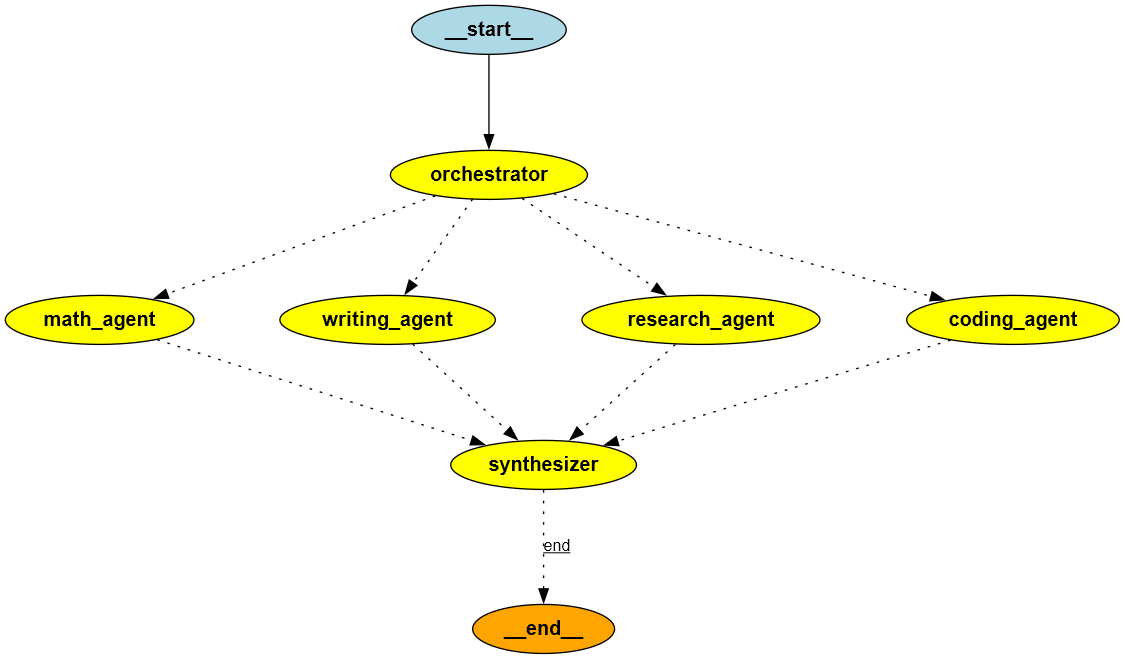

In [6]:
from IPython.display import Image, display
display(Image(router_orchestrator.get_graph().draw_png()))

In [7]:
# Usage function
def run_router_orchestrator(task: str) -> Dict[str, Any]:
    """Run the router/orchestrator system with a task"""
    # Clear call stack for new execution
    global call_stack
    call_stack = []
    call_stack.append("run_router_orchestrator: Starting execution")
    
    initial_state = AgentState(
        messages=[HumanMessage(content=task)],
        task=task,
        task_classification="",
        current_agent="orchestrator",
        agent_outputs={},
        final_response=""
    )
    
    result = router_orchestrator.invoke(initial_state)
    
    # Format the output for clarity
    output = {
        "task": task,
        "classified_agent": result["task_classification"],
        "agent_output": result["agent_outputs"].get(result["task_classification"], "No output"),
        "final_response": result["final_response"],
        "execution_trace": call_stack.copy()
    }
    
    call_stack.append("run_router_orchestrator: Execution completed")
    return output


In [8]:


# Test 1: Mathematical task
print("=== Router/Orchestrator Processing ===\n")

math_task = "Calculate the area of a circle with radius 7.5 meters, and then find the volume of a cylinder with the same radius and height 12 meters."
result1 = run_router_orchestrator(math_task)

print(f"Task: {result1['task']}")
print(f"Classified Agent: {result1['classified_agent']}")
print(f"Final Response: {result1['final_response']}")
print("\nExecution Trace:")
for step in result1['execution_trace']:
    print(f"  - {step}")

print("\n" + "="*60 + "\n")

# Test 2: Writing task
writing_task = "Write a short creative story about a robot learning to appreciate nature."
result2 = run_router_orchestrator(writing_task)

print(f"Task: {result2['task']}")
print(f"Classified Agent: {result2['classified_agent']}")
print(f"Final Response: {result2['final_response'][:300]}...")
print("\nExecution Trace:")
for step in result2['execution_trace']:
    print(f"  - {step}")

print("\n" + "="*60 + "\n")

# Test 3: Research task
research_task = "What are the main causes of climate change and their impacts on global biodiversity?"
result3 = run_router_orchestrator(research_task)

print(f"Task: {result3['task']}")
print(f"Classified Agent: {result3['classified_agent']}")
print(f"Final Response: {result3['final_response'][:300]}...")
print("\nExecution Trace:")
for step in result3['execution_trace']:
    print(f"  - {step}")

print("\n" + "="*60 + "\n")

# Test 4: Coding task
coding_task = "Write a Python function to find the longest common subsequence of two strings."
result4 = run_router_orchestrator(coding_task)

print(f"Task: {result4['task']}")
print(f"Classified Agent: {result4['classified_agent']}")
print(f"Final Response: {result4['final_response'][:300]}...")
print("\nExecution Trace:")
for step in result4['execution_trace']:
    print(f"  - {step}")

=== Router/Orchestrator Processing ===

Task: Calculate the area of a circle with radius 7.5 meters, and then find the volume of a cylinder with the same radius and height 12 meters.
Classified Agent: research_agent
Final Response: To calculate the area of a circle with radius $ r = 7.5 \, \text{m} $ and the volume of a cylinder with the same radius and height $ h = 12 \, \text{m} $, follow these steps:

---

### **1. Area of the Circle**  
**Formula**:  
$$
A = \pi r^2
$$  
**Calculation**:  
$$
A = \pi (7.5)^2 = \pi \times 56.25 \approx 3.1415926536 \times 56.25 \approx 176.7146 \, \text{m}^2
$$  
**Rounded to two decimal places**:  
$$
A \approx 176.71 \, \text{m}^2
$$  
**Symbolic form**:  
$$
A = 56.25\pi \, \text{m}^2
$$

---

### **2. Volume of the Cylinder**  
**Formula**:  
$$
V = \pi r^2 h
$$  
**Calculation**:  
$$
V = \pi (7.5)^2 \times 12 = \pi \times 56.25 \times 12 = \pi \times 675 \approx 3.1415926536 \times 675 \approx 2120.5752 \, \text{m}^3
$$  
**Rounded to two deci